# Learning Gate - Reto 
## Optimizar un modelo para predecir las cancelaciones en reservaciones hoteleras

#### Data Science Fundamentals - Visualización con machine learning (Classification)

###  Introduccion:

Ahora que ya conoces diferentes técnicas estadísticas y de visualización para tomar decisiones que te ayudan a mejorar el desempeño de tus modelos de máquinas inteligentes, deberás ayudar a Belén y a Juan a producir una máquina inteligente para ayudar al consorcio de hoteles a contar con un plan para reducir las cancelaciones de reservaciones. Recuerda que el objetivo es que Juan pueda entregar una máquina inteligente que pueda estimar las probabilidades de cancelación, así como separar a los clientes que van a cancelar de los que no. Estos resultados servirán a Belén para formular las estrategias para retener a los clientes y promocionar el destino, por lo que es necesario que ayudes a Juan a obtener un modelo con el menor error de clasificación posible.  

### Objetivo

**El objetivo general del reto consiste en:**

- Producir un modelo de clasificación optimizado que ayude estimar las probabilidades de cancelación de reservaciones hoteleras. 

**Los objetivos específicos son:**

- Producir un flujo de trabajo para un modelo de clasificación con técnicas estadísticas y de visualización para reducir el error de clasificación.
- Reportar el error de clasificación con el conjunto de prueba.
- Generar un CSV con tres columnas utilizando el conjunto de prueba: el id de la reservación, la probabilidad de cancelación y la clasificación de cancelación (0 ó 1)
- Justificar las decisiones de modelación para obtener el mejor modelo.

### Importing Libraries

In [35]:
import os, glob, math
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, LearningCurveDisplay, ShuffleSplit, train_test_split
from yellowbrick.model_selection import ValidationCurve, RFECV, FeatureImportances
from yellowbrick.classifier.threshold import DiscriminationThreshold
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassPredictionError
from Functions.Functions import fun_plot_grid_search_results

%matplotlib inline

### Loading Data

In [2]:
path = os.path.join(os.getcwd(), 'Data')
files = glob.glob(os.path.join(path, '*.csv'))

df = pd.read_csv(files[0])

display(df.head(5))

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Characteristics for the Data Loaded

- ***General Information***

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

- ***Null Values***

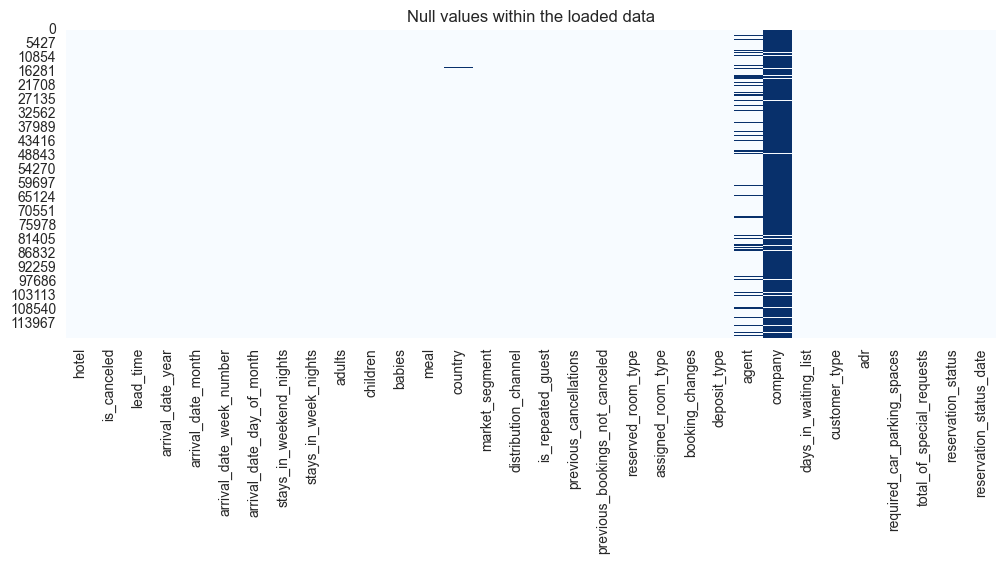

In [4]:
#Investigate patterns in the amount of missing values in the dataframe columns
fig, ax = plt.subplots(figsize=(12,4))  
sns.heatmap(df.isnull(), cbar=False,cmap="Blues", ax=ax);
ax.set_title('Null values within the loaded data');

- ***Imputing Null Values***

As a result of the NaN analysis, the **company** feature will be removed due to its high percentage of null values. Meanwhile, the missing values in the **agent** and **country** features will be imputed with 0 and 'OTHER', respectively.

In [5]:
df.drop(['company'], axis=1, inplace=True)
df.agent.fillna(0, inplace=True)
df.loc[df.index[df.country.isna()], 'country'] = 'OTHER'
df.dropna(inplace=True)

### Exploratory Data Analysis

#### Exploring characteristics of categorical variables

In [6]:
bias_res = {}
cols2rem = []
classes = []
catfeatures = df.nunique().index[(df.nunique().values<=20) & ((df.nunique().values>0))]

for col in catfeatures:
    bias_results = [case/df.shape[0] for case in df[col].value_counts() if case/df.shape[0]>.9]
    if len(bias_results)>0:
        cols2rem.append(col)
        classes.append(bias_results[0])

display(pd.DataFrame({'Cols_2_Remove':cols2rem, 'Class_Bias_Ratio':classes}))

,Cols_2_Remove,Class_Bias_Ratio
0,children,0.928049
1,babies,0.992319
2,is_repeated_guest,0.968087
3,previous_cancellations,0.945689
4,required_car_parking_spaces,0.937882


As discussed earlier, some columns will be removed due to their strong bias toward a specific class. However, we also considered how important these features might be in identifying relationships with the target variable. Therefore, the following actions will be taken:

- Removal of the **babies** feature: Although this feature could be crucial for determining whether guests are likely to cancel their reservation, the overwhelming bias toward one class (99%) makes it uninformative. As a result, it will be removed.
- Removal of the **arrival_date_year**: This action is implemented sin seasonality will be considered using the arrival month feature, since years are not enough within the provided data to have an important seasonal effect.

The remaining features that exhibit class bias will be retained, as they may still play a significant role in uncovering key relationships.

In [7]:
df.drop(['babies', 'arrival_date_year'], axis=1, inplace=True)

- ***Converting non numerical categorical variables to numeric***

In [8]:
enc = OrdinalEncoder(dtype=int)
cols2encode = df.columns[(df.dtypes=='object')].tolist()
df[cols2encode] = enc.fit_transform(df[cols2encode].values)

display(df[cols2encode].head())

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,1,5,0,136,3,1,2,2,0,2,1,121
1,1,5,0,136,3,1,2,2,0,2,1,121
2,1,5,0,59,3,1,0,2,0,2,1,122
3,1,5,0,59,2,0,0,0,0,2,1,122
4,1,5,0,59,6,3,0,0,0,2,1,123


#### Exploring behaivours of non-categorical variables

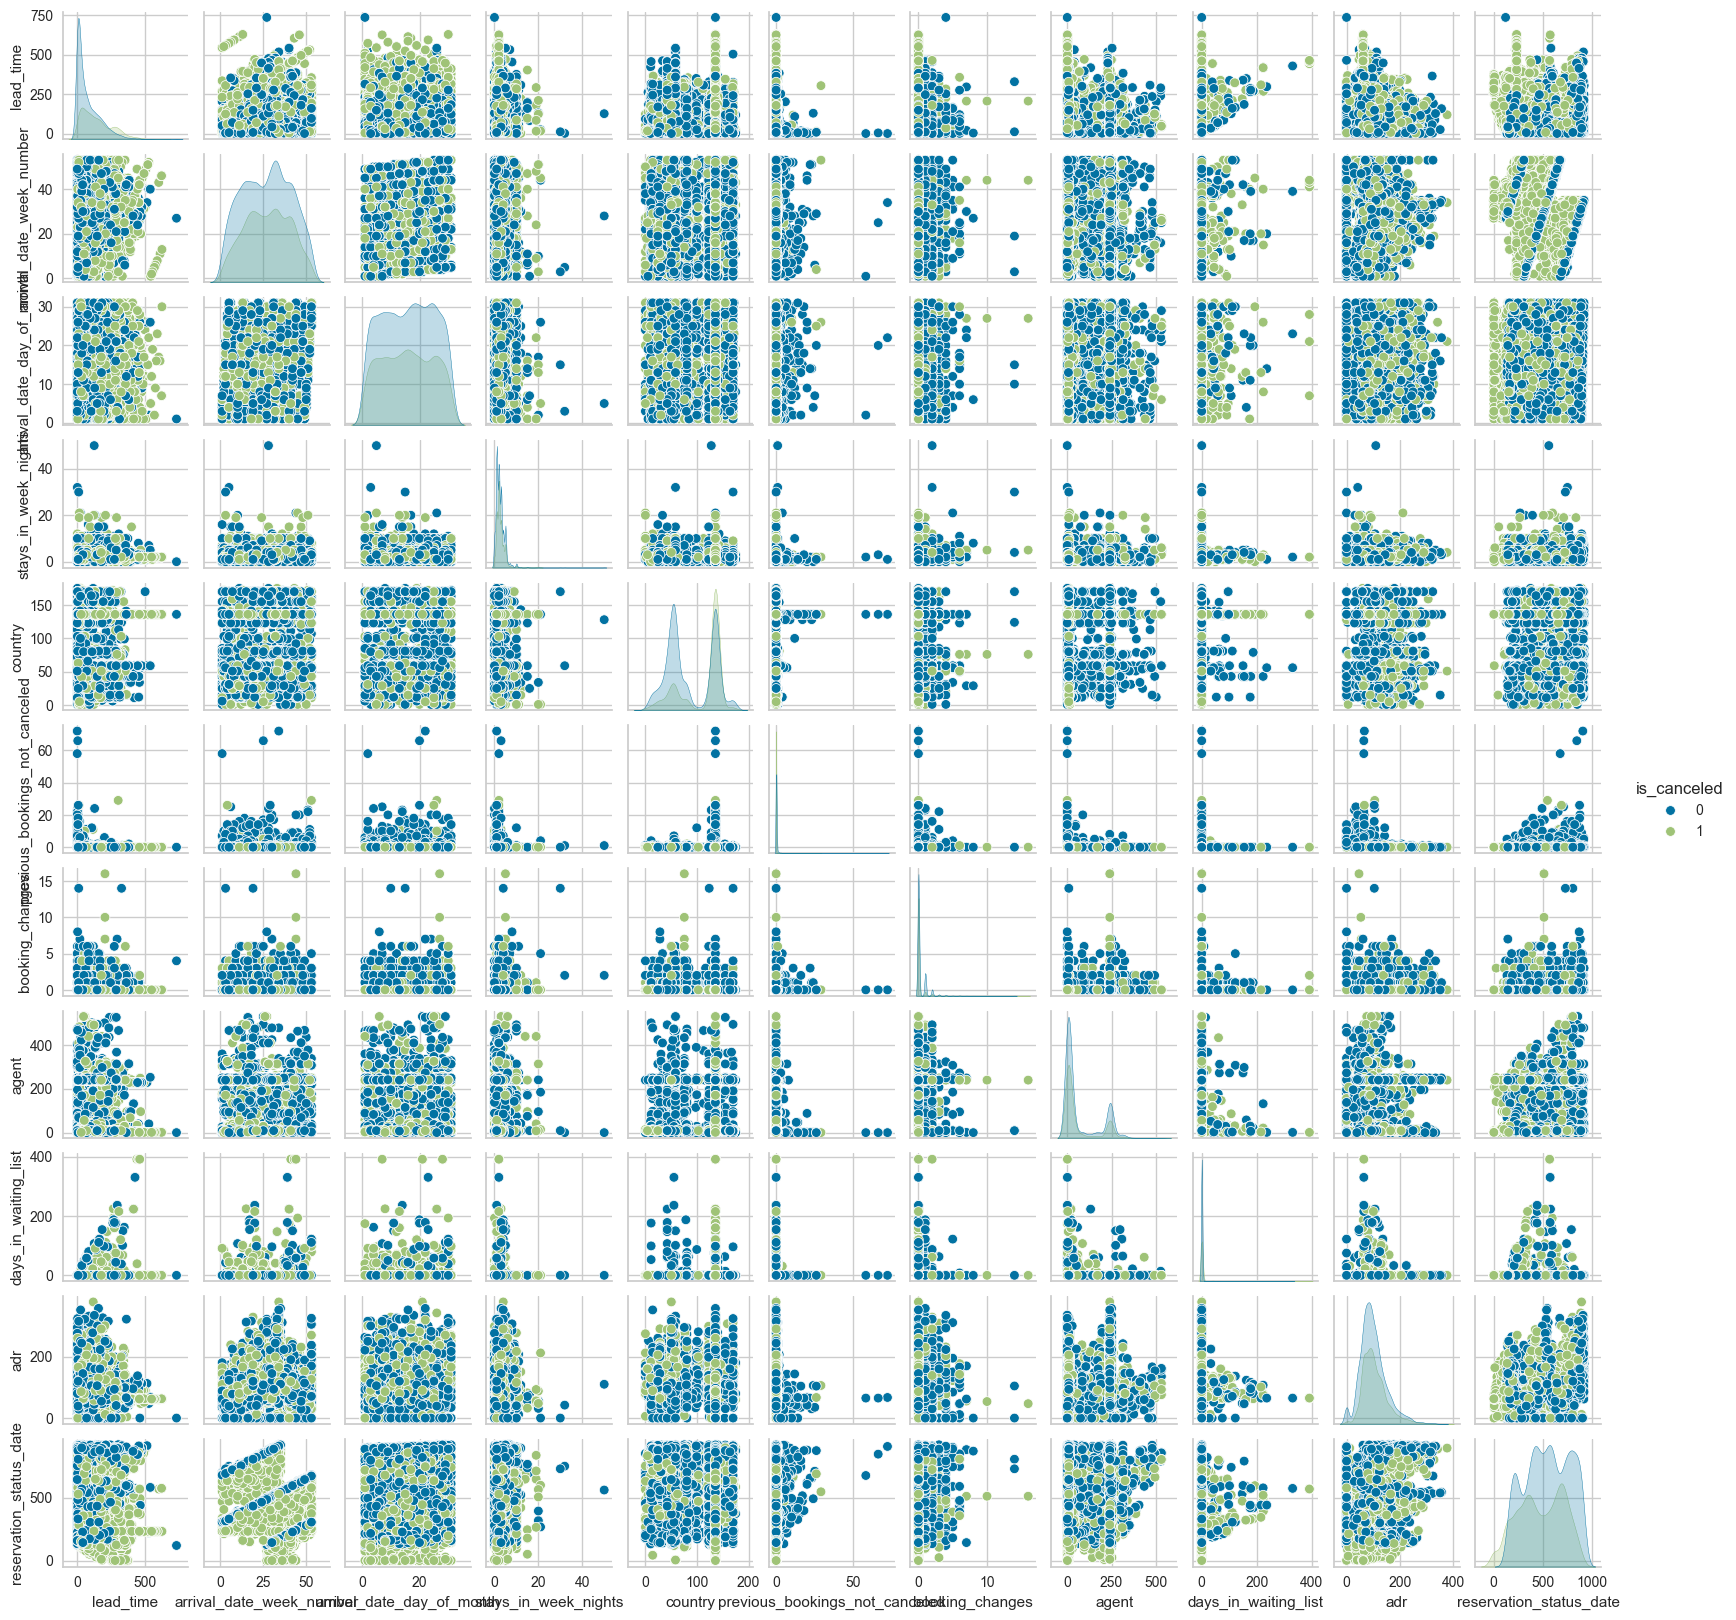

In [9]:
numfeat = [col for col in df.columns if col not in catfeatures]
target = 'is_canceled'
sns.pairplot(df[numfeat + [target]].sample(int(df.shape[0]/10)), hue=target, height=1.5);

- ***Non-categorical variables statistics:***

In [10]:
df[numfeat].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,119386.0,104.014801,106.863286,0.00,18.00,69.00,160.0,737.0
arrival_date_week_number,119386.0,27.165003,13.605334,1.00,16.00,28.00,38.0,53.0
arrival_date_day_of_month,119386.0,15.798553,8.780783,1.00,8.00,16.00,23.0,31.0
stays_in_week_nights,119386.0,2.500310,1.908289,0.00,1.00,2.00,3.0,50.0
country,119386.0,93.591351,45.094463,0.00,56.00,81.00,136.0,177.0
previous_bookings_not_canceled,119386.0,0.137102,1.497462,0.00,0.00,0.00,0.0,72.0
booking_changes,119386.0,0.221131,0.652315,0.00,0.00,0.00,0.0,21.0
agent,119386.0,74.830633,107.142996,0.00,7.00,9.00,152.0,535.0
days_in_waiting_list,119386.0,2.321227,17.595011,0.00,0.00,0.00,0.0,391.0
adr,119386.0,101.833541,50.534664,-6.38,69.29,94.59,126.0,5400.0


#### Multicollinearity Analysis

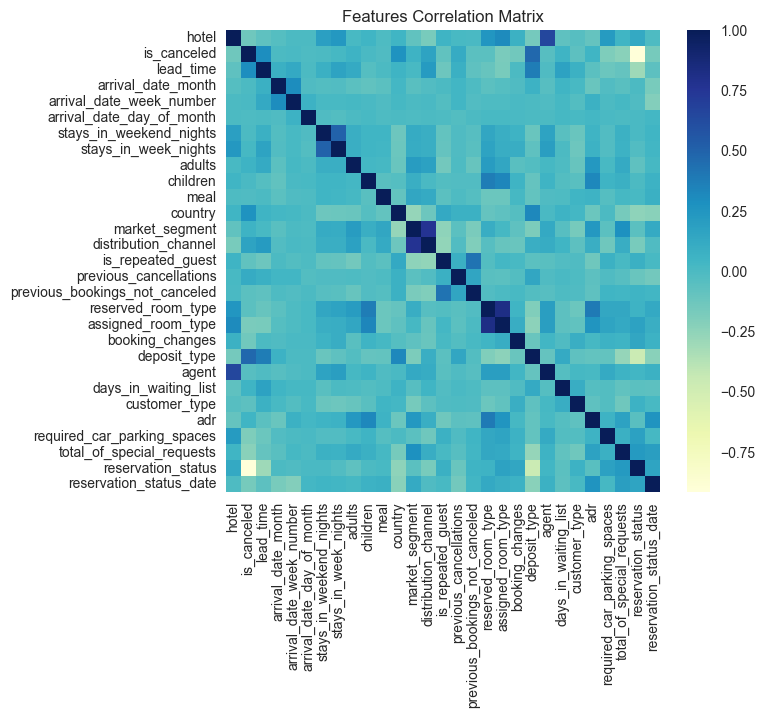

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
dataplot = sns.heatmap((df.corr(numeric_only=True)), cmap="YlGnBu", annot=False, ax=ax)
ax.set_title('Features Correlation Matrix');

- ***Removing highly linearly correlated faetures:***

In [12]:
df.drop('reservation_status', axis=1, inplace=True)

#### Conclusions

The solution will be implemented using decision trees, at least in the initial stage. Since these algorithms are robust and not significantly affected by the lack of normality in the data, no transformations will be applied to the analyzed data.

## Identifying cases of clients canceling reservations

### Creating datasets for training, validation and test for the generated models

In [13]:
# Creating datasets
features = [col for col in df.columns if col not in ['is_canceled']]#, 'deposit_type']]
target = ['is_canceled']
X = df[features].values
Y = df[target].values
X_train_base, X_test, y_train_base, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, test_size=0.25, stratify=y_train_base, random_state=42)

# Evaluating the size of the created datasets
print('Data percentage for the test set, with respect of the original size of the loaded data: ', X_test.shape[0]/df.shape[0])
print('Data percentage for the validation set, with respect of the original size of the loaded data: ',X_val.shape[0]/df.shape[0])
print('Data percentage for the train set, with respect of the original size of the loaded data: ',X_train.shape[0]/df.shape[0])

Data percentage for the test set, with respect of the original size of the loaded data:  0.25000418809575664
Data percentage for the validation set, with respect of the original size of the loaded data:  0.18750104702393916
Data percentage for the train set, with respect of the original size of the loaded data:  0.5624947648803043


### Generating the Machine Learning Model to Classify Guest Reservation Status

#### Training the Model

- ***Selecting the Model Algorithm***

In [14]:
clf_base = RandomForestClassifier(n_estimators=4, random_state=10)

- ***Analyzing its learning process***

As can be observed in the next Figure, the model presents good performance classifying classes of interest, even in its intial form with a limited complexity. More importantly, even when the performance during the training process is greater than the performance of the model during the validation process, it can be observe that the model is not too overfitted, since the performance of the model during the training process increases as well as during tha validation process. 

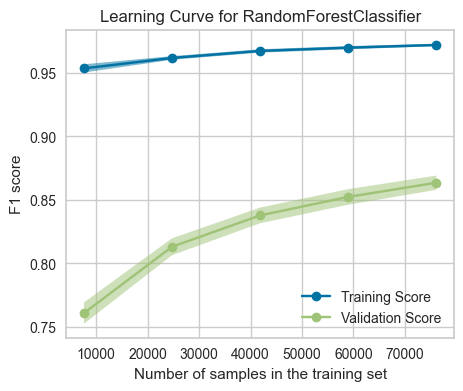

In [15]:
fig, ax = plt.subplots(1,1, figsize=(5, 4), sharex=True)

common_params = {
    "X": X_train_base,
    "y": y_train_base,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.15, random_state=0),
    'scoring':'f1',
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "F1 score",
}

clf_base = RandomForestClassifier(n_estimators=4, random_state=10)

for ax_idx, estimator in enumerate([clf_base]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Validation Score"])
    ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")
    

  - ***Training the Model***

In [16]:
clf_base.fit(X_train,y_train.transpose()[0])

RandomForestClassifier(n_estimators=4, random_state=10)

#### Model Evaluation

- ***Confusion Matrix***

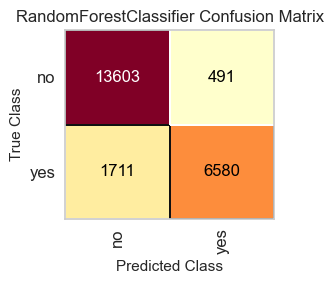

In [17]:
fig1, ax = plt.subplots(figsize = (3,3))
cm = ConfusionMatrix(clf_base, classes=['no', 'yes'], ax=ax)
cm.fit(X_train, y_train.transpose()[0])
cm.score(X_val, y_val.transpose()[0])
cm.show();

- ***ROC Curve and AUC***

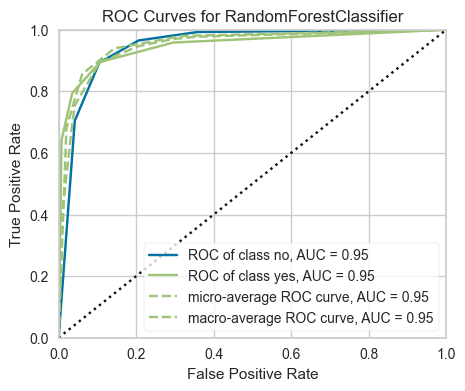

In [18]:
fig2, ax = plt.subplots(figsize = (5,4))
roc_curves_visualizer = ROCAUC(clf_base, classes=['no', 'yes'], ax=ax)
roc_curves_visualizer.fit(X_train, y_train.transpose()[0])
roc_curves_visualizer.score(X_val, y_val.transpose()[0])
roc_curves_visualizer.show(ax=ax);

- ***Clasification Performance Report***

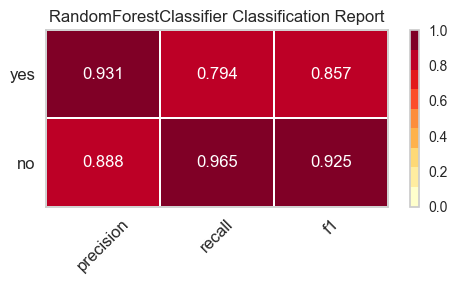

In [19]:
fig, ax = plt.subplots(figsize = (5,3))
visualizer = ClassificationReport(clf_base, classes=['no', 'yes'], ax=ax)
visualizer.fit(X_train, y_train.transpose()[0])
visualizer.score(X_val, y_val.transpose()[0])
visualizer.show();  

#### Conclusion

The trained base model maintains simplicity while demonstrating solid performance, as evidenced by the previously presented confusion matrix, ROC curve, AUC score, and the classification report. These metrics show that the model accurately predicts most cases of guests who either cancel or do not cancel their reservations. However, the model still makes some errors, such as predicting false cancellations and false non-cancellations.

The ROC curve reveals that the model performs well for both classes, with an AUC close to 1 and an error rate of approximately 5% when predicting true positives and true negatives.

Lastly, the classification report shows that the model generally performs well but is more effective at identifying guests who do not cancel their reservations. This is expected since the model exhibits a bias toward that specific class. The next steps in this notebook will focus on improving the model’s performance by reducing the bias present in the data toward one class.

### Improving the Classification of Guests

The initial model maintains simplicity while delivering solid performance. However, there is potential to enhance its performance due to its low complexity. To achieve this, it's essential to carefully consider the precision-recall trade-off when adjusting the model’s parameters

#### Removing Unimportant Features

By utilizing the Yellowbrick library's FeatureImportances tool, we can analyze the impact of each input feature on the model's performance. Features with low influence will be removed to minimize inconsistencies and improve overall efficiency

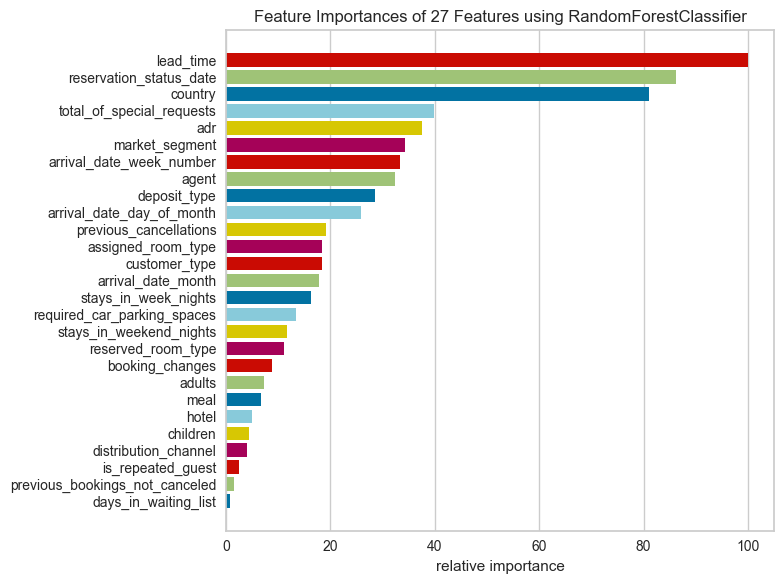

In [20]:
# Especificamos la gráfica
fig, ax = plt.subplots(figsize = (8,6))
viz = FeatureImportances(clf_base) 	# Pasar el estimador del mejor modelo que 
    									# se obtiene de la validación cruzada.
# Ajustamos la visualización a los datos de entrenamiento
viz.fit(pd.DataFrame(X_train_base, columns=features), y_train.transpose()[0])
# Dibjuamos la visualización.
viz.show();

thrsld = 20
new_features = viz.features_[viz.feature_importances_>thrsld]

#### Creating the Training, Validation, and Test Datasets

Using the newly selected input features, datasets will be generated for training, validation, and testing of the chosen machine learning algorithm. The proportions of these datasets relative to the total available data will remain consistent with those used in the previous model.

In [21]:
# Creating datasets
target = ['is_canceled']
X = df[new_features].values
Y = df[target].values
X_train_base, X_test, y_train_base, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, test_size=0.25, stratify=y_train_base, random_state=42)

# Evaluating the size of the created datasets
print('Data percentage for the test set, with respect of the original size of the loaded data: ', X_test.shape[0]/df.shape[0])
print('Data percentage for the validation set, with respect of the original size of the loaded data: ',X_val.shape[0]/df.shape[0])
print('Data percentage for the train set, with respect of the original size of the loaded data: ',X_train.shape[0]/df.shape[0])

Data percentage for the test set, with respect of the original size of the loaded data:  0.25000418809575664
Data percentage for the validation set, with respect of the original size of the loaded data:  0.18750104702393916
Data percentage for the train set, with respect of the original size of the loaded data:  0.5624947648803043


#### Finding the Best Hyperparameters for the Selected ML Algorithm

The GridSearchCV method from scikit-learn will be used to evaluate the performance of the selected model and identify the best combination of hyperparameters that yield the highest performance. The range of hyperparameters to be tested is based on the performance of the previously trained model, which delivered adequate results with low complexity. By increasing the model’s complexity, it is expected an overall enhance in the model performance.

In [22]:
# Especificar bosque aleatorio
clf_rf = RandomForestClassifier(n_estimators=4, class_weight='balanced', random_state=10)

# Especificar la combinación de parámetros que queremos explroar.
params = {'n_estimators':[5, 10, 20, 50], 'max_depth':[5, 10, 15, 20], 'min_samples_split':[2, 3, 4, 5],
          'min_samples_leaf':[1, 2, 4]}

# Especificar el GridSearch con validación cruzada
grid_search = GridSearchCV(clf_rf, params, scoring = 'roc_auc', cv = 10,
                           return_train_score=True, n_jobs=-1)

# Entrenar los modelos
grid_search.fit(X_train, y_train.transpose()[0])

# Recupearar los resultados de la validación cruzada
df_best_params = pd.DataFrame(grid_search.cv_results_)

# Displaying obtained results, the best 5 trained models
tabla_resultados = fun_plot_grid_search_results(df_best_params)
display(tabla_resultados.data.head())

,max_depth,min_samples_leaf,min_samples_split,n_estimators,mean_train_score,mean_test_score,rank_test_score
147,20,1,2,50,0.999688,0.974868,1
151,20,1,3,50,0.999549,0.974820,2
155,20,1,4,50,0.999291,0.974526,3
159,20,1,5,50,0.999043,0.974338,4
175,20,2,5,50,0.998313,0.973573,5


#### Evaluating the Learning Process of the Selected ML Model

The learning curves of the selected ML model are analyzed to detect any signs of overfitting or underfitting. As shown below, both curves behaves like they will converge at some point, indicating the absence of significant overfitting or underfitting. Furthermore, the model's performance, measured by the F1-score, is strong.

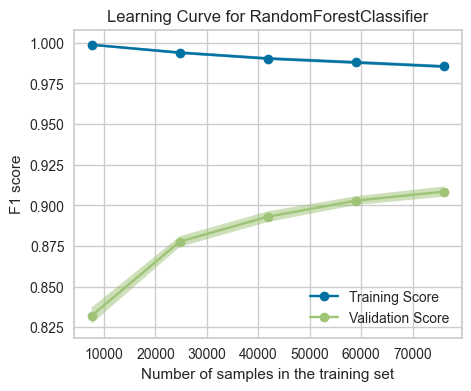

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5, 4), sharex=True)

common_params = {
    "X": X_train_base,
    "y": y_train_base,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.15, random_state=0),
    'scoring':'f1',
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "F1 score",
}

clf_rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split= 2, n_estimators= 50, class_weight='balanced', random_state=10)

for ax_idx, estimator in enumerate([clf_rf]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Validation Score"])
    ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")
    

- ***Defining the model to use***

In [24]:
print('Best parameters: \n', grid_search.best_params_)
clf_rf = grid_search.best_estimator_

Best parameters: 
 {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


#### Evaluating the Performance of the Trained Model

The trained model is evaluated to determine its performance when predicting if a guest will cancel or not its reservation. Three different metrics are used to measure the mentioned performance, the confusion matrix, the ROC curve and its AUC and a table that compares the model precision, recall and F1-score. 

- ***Confusion Matrix***

The confusion matrix for the trained machine learning model's predictions is presented in the table below. It shows that the model performs well in correctly identifying both true positives and true negatives. However, while the proportion of misclassified instances is small, misclassifications do occur, as evident in the non-diagonal elements of the matrix.

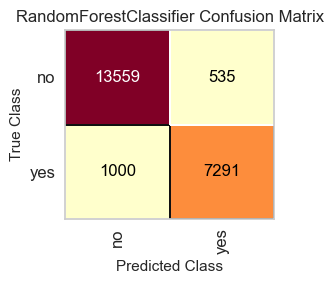

In [25]:
fig1, ax = plt.subplots(figsize = (3,3))
cm = ConfusionMatrix(clf_rf, classes=['no', 'yes'], ax=ax)
cm.fit(X_train, y_train.transpose()[0])
cm.score(X_val, y_val.transpose()[0])
cm.show();

- ***ROC curve and AUC score***

A complementary metric to assess the performance of the trained model is the ROC curve, which plots the model's sensitivity (true positive rate) against 1-specificity (false positive rate). As shown in the figure below, the model performs very well in correctly classifying the classes of interest, with AUC scores approaching 1 for both classes.

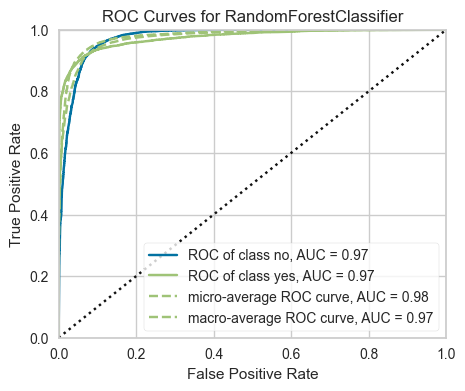

In [26]:
fig2, ax = plt.subplots(figsize = (5,4))
roc_curves_visualizer = ROCAUC(clf_rf, classes=['no', 'yes'], ax=ax)
roc_curves_visualizer.fit(X_train, y_train.transpose()[0])
roc_curves_visualizer.score(X_val, y_val.transpose()[0])
roc_curves_visualizer.show(ax=ax);

- ***Summary of scores to assess the performance of the model***

The following table presents various performance metrics for the trained model when predicting whether a hotel guest will keep or cancel their reservation. The precision metric shows similar performance across both classes, indicating that the model is equally accurate in predicting cancellations and non-cancellations. However, the recall metric improves upon the precision for predicting guests who will not cancel their reservations, reflecting the model's better ability to identify these cases.

Unfortunately, the model's recall is lower when predicting guests who will cancel their reservations, indicating that it struggles to correctly identify all potential cancellations. This discrepancy, compared with the precision score for the same class, suggests the presence of some false positives when identifying cancellations.

Lastly, the F1-score—which balances both precision and recall—demonstrates good overall performance for both classes. However, it performs slightly better for the class with more examples in the dataset, which reflects the model's stronger performance in more common scenarios.

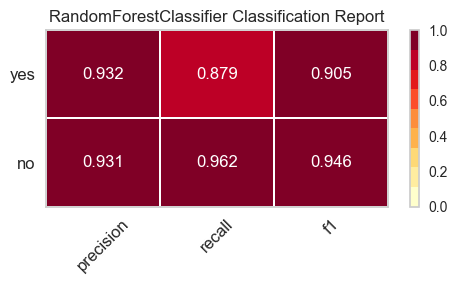

In [27]:
fig, ax = plt.subplots(figsize = (5,3))
visualizer = ClassificationReport(clf_rf, classes=['no', 'yes'], ax=ax)
visualizer.fit(X_train, y_train.transpose()[0])
visualizer.score(X_val, y_val.transpose()[0])
visualizer.show();  

### Predicting Hotel Guests with a High Probability of Cancelling Their Reservations

The model trained in the previous section will be employed for the task of predicting hotel guests with a high likelihood of canceling their reservations. Since the model demonstrated strong performance in identifying clients with a high tendency to cancel, it is suitable for this application.

To evaluate its effectiveness, the prediction will be implemented on the testing dataset, allowing for an assessment of the model's performance in a real-world scenario. This dataset contains guest behaviors that the model has not seen before, providing a true test of its ability to generalize and make accurate predictions on new data.

#### Making Predictions

In [38]:
y_pred = clf_rf.predict(X_test)

print('Recall Score: ', recall_score(y_test, y_pred))
print('Precision Score: ', precision_score(y_test, y_pred))

Recall Score:  0.8854816824966079
Precision Score:  0.9320194230219937


- ***Saving the predicted results***

In [67]:
Cancelation_prob = clf_rf.predict_proba(df[new_features].values).T[0]
Predicted_Cancelation = clf_rf.predict(df[new_features].values)
Canceled_Reservation = df.is_canceled.values
Results_df = pd.DataFrame({'Reservation_id':df.index.values, 'Cancelation_Probability':1-Cancelation_prob,
                           'Predicted_Cancellation':Predicted_Cancelation, 'Cancelled_Reservation':Canceled_Reservation})
Results_df.set_index('Reservation_id', inplace=True)

Results_df.to_csv(os.path.join(os.getcwd(), 'Results', 'DS_C6_SC1_JoseAlfosoSanchezDeLucio.csv'))

#### Evaluating Performance of the Predictions

- ***Confusion Matrix***

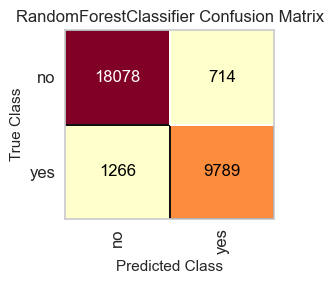

In [31]:
fig1, ax = plt.subplots(figsize = (3,3))
cm = ConfusionMatrix(clf_rf, classes=['no', 'yes'], ax=ax)
cm.fit(X_train, y_train.transpose()[0])
cm.score(X_test, y_test.transpose()[0])
cm.show();

- ***ROC Curve***

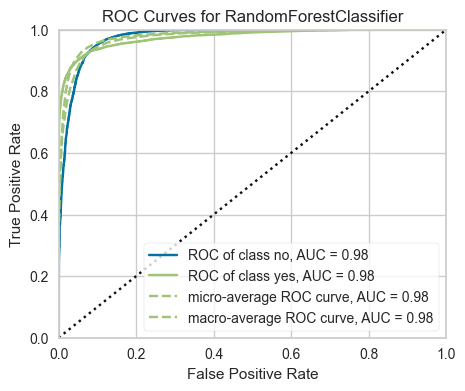

In [32]:
fig2, ax = plt.subplots(figsize = (5,4))
roc_curves_visualizer = ROCAUC(clf_rf, classes=['no', 'yes'], ax=ax)
roc_curves_visualizer.fit(X_train, y_train.transpose()[0])
roc_curves_visualizer.score(X_test, y_test.transpose()[0])
roc_curves_visualizer.show(ax=ax);

- ***Clasification Report***

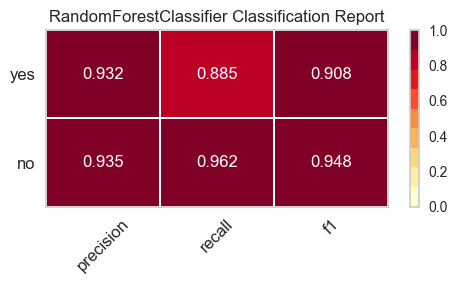

In [34]:
fig, ax = plt.subplots(figsize = (5,3))
visualizer = ClassificationReport(clf_rf, classes=['no', 'yes'], ax=ax)
visualizer.fit(X_train, y_train.transpose()[0])
visualizer.score(X_test, y_test.transpose()[0])
visualizer.show();  

#### Results

The results of predicting hotel guests with a high probability of canceling their reservations are presented in this section. Based on these results, it can be concluded that the model behaves as expected, consistent with its performance during the training phase. Specifically, when comparing the predictions made on the testing dataset with those from the validation phase, the model demonstrates similar performance.

The evaluation metrics obtained from the testing dataset closely align with those from the validation set, further confirming the model's ability to accurately identify guests who are likely to cancel their reservations. This consistency highlights the model's strong predictive capability and reliability when applied to real-world data.

## Conclusions

It can be concluded that, based on the obtained results, the model proves to be adequate for the required task and effectively addresses the presented problem. This is supported by the performance metrics from both the validation and testing sets. Notably, the precision and recall metrics provide valuable insights into customer behavior, particularly in identifying guests who are unlikely to cancel their reservations. This can help hotels minimize losses by more accurately forecasting room occupancy and managing bookings more efficiently.

Equally important, the model offers valuable predictions for guests who have a high probability of canceling their reservations. While predicting cancellations is not the model’s strongest characteristic, it still provides a reliable estimation, as demonstrated by the recall scores. This capability allows hotels to take proactive measures, such as targeted retention strategies, to further reduce cancellations.

## FIN